In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [2]:
xls = pd.ExcelFile('../../../data/raw/partner_i/Dados Históricos - partner_i.xlsx', engine='openpyxl')
df = pd.read_excel(xls, 'CPIIF40', na_values='-')

# Removing Useless Features

Here we will drop some features that may not contribute to the performance of the models that will be fitted on this data. Here is provided a list of the variables and the reason why they are being removed.

<table>
  <tr>
    <th>Feature</th>
    <th>% Missing alues</th>
  </tr>
  <tr>
    <td>AE7D</td>
    <td>87.23%</td>
  </tr>
  
  <tr>
    <td>AE1D</td>
    <td>83.13%</td>
  </tr>
  
  <tr>
    <td>AE28D</td>
    <td>83.86%</td>
  </tr>

  <tr>
    <td>MUSCOVITA</td>
    <td>63.37%</td>
  </tr>
  
  <tr>
    <td>FALSAP</td>
    <td>47.34%</td>
  </tr>
    
  <tr>
    <td>ANIDRITA</td>
    <td>77.10%</td>
  </tr>
</table>

<br>

<table>
    <tr>
    <th>Feature</th>
    <th>% of Zeros</th>
  </tr>
  <tr>
    <td>#200</td>
    <td>59.76%</td>
  </tr>
    
  <tr>
    <td>FLUORITA</td>
    <td>50.60%</td>
  </tr>
  
  <tr>
    <td>DOLOMITA<td>
    <td>50.12%<td>
  </tr>
  
  <tr>
    <td>ANIDRITA<td>
    <td>42.41%<td>
  </tr>
</table> 

In [3]:
to_drop = ['ANIDRITA', 'MUSCOVITA', 'FALSAP', 'AE1D', 'AE28D', 'AE7D', 'ANIDRITA', 'DOLOMITA', 'FLUORITA', '#200']

In [4]:
df.drop(columns=to_drop, inplace=True)

# Resampling

Since the dates are not uniformly distributed we shall resample it. The original dataset is mostly sampled by an interval of 2 days. Sometimes the inverval is of 3 days. Since we are going to do upscaling, it will require to use some imputation method to fill missing values that will appear after resampling. Thus, we will do a grid search on a linear baseline model to find the best imputation method.

<h3>Grid CV - Imputation methods with resampling of 24H and 48H</h3>

In [5]:
df = df.set_index("Data/Hora")
scaler = StandardScaler()
model = LinearRegression()
seed = 47

In [6]:
def get_pipelines_data_transformed(data, cols_to_remove=None):
    pipelines = list()
    granularity = '1D'
    
    # resample 24h
    data_copy = data.copy()
    data_copy = data_copy.resample(granularity).asfreq()
    if cols_to_remove is not None:
            data_copy = data_copy.drop(cols_to_remove, axis=1)
    # fillna with zeros
    pipelines.append(('24h-impute-zero', data_copy.fillna(0)))
    
    # fillna with mean
    pipelines.append(('24h-impute-mean', data_copy.fillna(data_copy.mean())))
    
    # fillna with forward and backward fill
    pipelines.append(('24h-impute-forward-backward-fill', data_copy.fillna(method='ffill').fillna(method='bfill')))
    
    # interpolate - linear method
    data_copy = data.resample(granularity)
    pipelines.append(('24h-impute-interpolate-linear', data_copy.interpolate(method='linear', limit_direction="both",)))
    
    # interpolate - spline method
    data_copy = data.resample(granularity)
    pipelines.append(('24h-impute-interpolate-spline', data_copy.interpolate(method='spline', limit_direction="both", order=2)))
    
    # resample 48h
    granularity = '2D'
    data_copy = data.copy()
    data_copy = data_copy.resample(granularity).asfreq()
    if cols_to_remove is not None:
            data_copy = data_copy.drop(cols_to_remove, axis=1)
    
    # fillna with zeros
    pipelines.append(('48h-impute-zero', data_copy.fillna(0)))
    
    # fillna with mean
    pipelines.append(('48h-impute-mean', data_copy.fillna(data_copy.mean())))
    
    # fillna with forward and backward fill
    pipelines.append(('48h-impute-forward-backward-fill', data_copy.fillna(method='ffill').fillna(method='bfill')))
    
    # interpolate - linear method
    data_copy = data.resample(granularity)
    pipelines.append(('48h-impute-interpolate-linear', data_copy.interpolate(method='linear', limit_direction="both",)))
    
    # interpolate - spline method
    data_copy = data.resample(granularity)
    pipelines.append(('48h-impute-interpolate-spline', data_copy.interpolate(method='spline', limit_direction="both", order=2)))
        
    return pipelines

<h3>GridCV - Without R3D And R7D vars<h3>

In [7]:
results, names = list(), list()
pipeline = Pipeline([('transformer', scaler), ('estimator', model)])
cols_to_remove = ['R3D', 'R7D']

for name, data in get_pipelines_data_transformed(df, cols_to_remove):
    y = data.pop('R28D').values
    x = data.values    
    scores = cross_val_score(pipeline, x,y, cv=10, scoring='neg_root_mean_squared_error')
    scores = np.abs(scores)
    results.append(scores)
    names.append(name)
    print('>%s: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

mean_results = list(map(np.mean, results))
index = np.argmin(mean_results)
name = names[index]
print("\nBest method:", name, '\nbest rmse score:', mean_results[index])

/home/felipe/Documents/ccs28-venv/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


>24h-impute-zero: 11.910 (3.178)
>24h-impute-mean: 1.290 (0.317)
>24h-impute-forward-backward-fill: 2.089 (0.426)
>24h-impute-interpolate-linear: 1.573 (0.499)
>24h-impute-interpolate-spline: 37.658 (44.566)
>48h-impute-zero: 13.010 (4.363)
>48h-impute-mean: 1.376 (0.536)
>48h-impute-forward-backward-fill: 2.841 (1.029)
>48h-impute-interpolate-linear: 1.975 (0.700)
>48h-impute-interpolate-spline: 2.173 (1.007)

Best method: 24h-impute-mean 
best rmse score: 1.2898008689077773


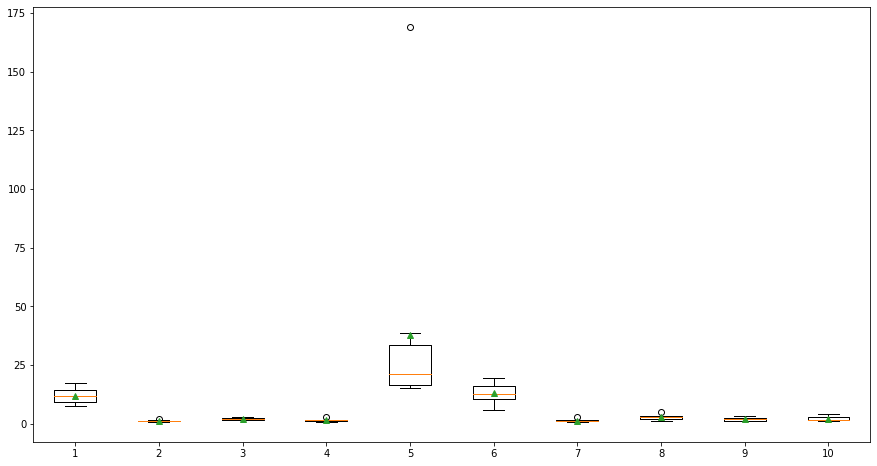

In [8]:
plt.figure(figsize=(15,8))
plt.boxplot(results, showmeans=True)
plt.show()

<h3>GridCV - Without R7D var<h3>

In [9]:
results, names = list(), list()
pipeline = Pipeline([('transformer', scaler), ('estimator', model)])
cols_to_remove = ['R3D']

for name, data in get_pipelines_data_transformed(df, cols_to_remove):
    y = data.pop('R28D').values
    x = data.values    
    scores = cross_val_score(pipeline, x,y, cv=10, scoring='neg_root_mean_squared_error')
    scores = np.abs(scores)
    results.append(scores)
    names.append(name)
    print('>%s: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

mean_results = list(map(np.mean, results))
index = np.argmin(mean_results)
name = names[index]
print("\nBest method:", name, '\nbest rmse score:', mean_results[index])


/home/felipe/Documents/ccs28-venv/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


>24h-impute-zero: 11.126 (2.986)
>24h-impute-mean: 0.996 (0.279)
>24h-impute-forward-backward-fill: 1.672 (0.383)
>24h-impute-interpolate-linear: 1.573 (0.499)
>24h-impute-interpolate-spline: 37.658 (44.566)
>48h-impute-zero: 12.400 (4.685)
>48h-impute-mean: 1.128 (0.402)
>48h-impute-forward-backward-fill: 2.507 (0.895)
>48h-impute-interpolate-linear: 1.975 (0.700)
>48h-impute-interpolate-spline: 2.173 (1.007)

Best method: 24h-impute-mean 
best rmse score: 0.9961807270769029


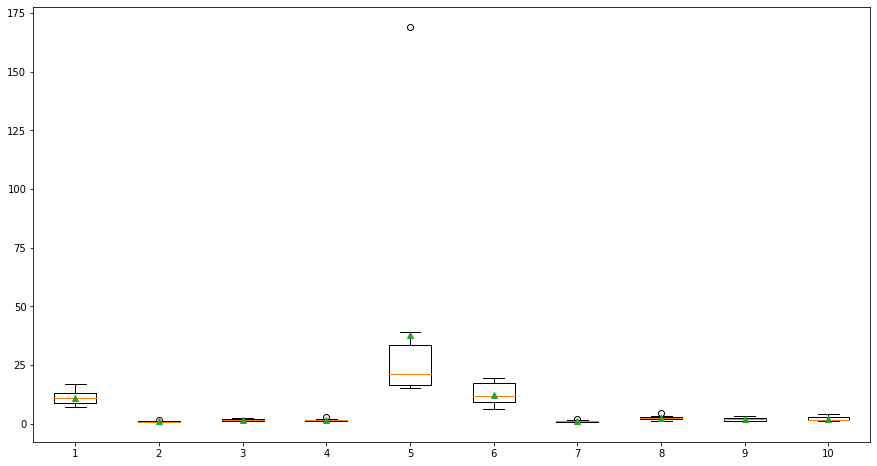

In [10]:
plt.figure(figsize=(15,8))
plt.boxplot(results, showmeans=True)
plt.show()

<h3>GridCV - All vars<h3>

In [11]:
results, names = list(), list()
pipeline = Pipeline([('transformer', scaler), ('estimator', model)])
cols_to_remove = None

for name, data in get_pipelines_data_transformed(df, cols_to_remove):
    y = data.pop('R28D').values
    x = data.values    
    scores = cross_val_score(pipeline, x,y, cv=10, scoring='neg_root_mean_squared_error')
    scores = np.abs(scores)
    results.append(scores)
    names.append(name)
    print('>%s: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

mean_results = list(map(np.mean, results))
index = np.argmin(mean_results)
name = names[index]
print("\nBest method:", name, '\nbest rmse score:', mean_results[index])

/home/felipe/Documents/ccs28-venv/lib/python3.6/site-packages/scipy/interpolate/fitpack2.py:253: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


>24h-impute-zero: 10.999 (3.392)
>24h-impute-mean: 1.004 (0.272)
>24h-impute-forward-backward-fill: 1.697 (0.391)
>24h-impute-interpolate-linear: 1.573 (0.499)
>24h-impute-interpolate-spline: 37.658 (44.566)
>48h-impute-zero: 12.447 (4.714)
>48h-impute-mean: 1.145 (0.392)
>48h-impute-forward-backward-fill: 2.558 (0.882)
>48h-impute-interpolate-linear: 1.975 (0.700)
>48h-impute-interpolate-spline: 2.173 (1.007)

Best method: 24h-impute-mean 
best rmse score: 1.0035752549355297


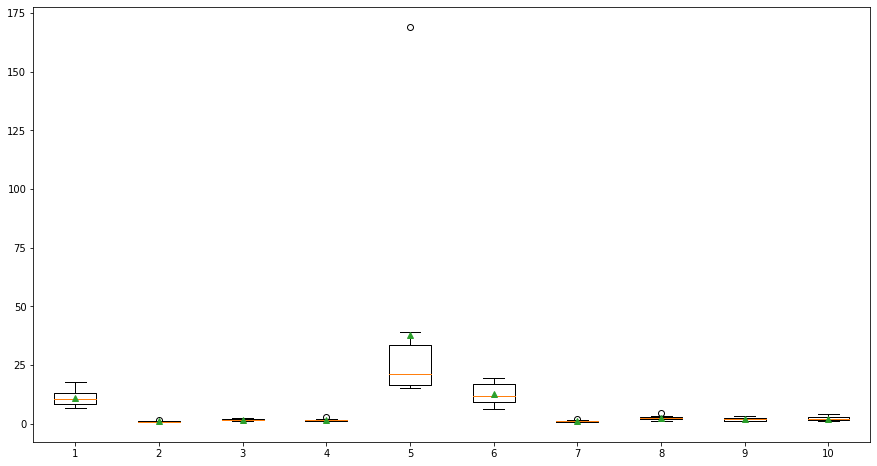

In [12]:
plt.figure(figsize=(15,8))
plt.boxplot(results, showmeans=True)
plt.show()

In [13]:
data = df.resample('24h').interpolate(method='linear', limit_direction="both")
y = data.pop('R28D').values
x = data.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=seed)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = LinearRegression()
model.fit(x_train, y_train)
r2 = model.score(x_test, y_test)
rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)

print("R^2:", r2)
print("RMSE:", rmse)

R^2: 0.5110731417654913
RMSE: 1.1799490144959912


In [14]:
data = df.resample('48h').interpolate(method='linear', limit_direction="both")
y = data.pop('R28D').values
x = data.values
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state=seed)
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

model = LinearRegression()
model.fit(x_train, y_train)
r2 = model.score(x_test, y_test)
rmse = mean_squared_error(y_test, model.predict(x_test), squared=False)

print("R^2:", r2)
print("RMSE:", rmse)

R^2: 0.553407576035605
RMSE: 1.2960309975328506


<AxesSubplot:xlabel='Data/Hora'>

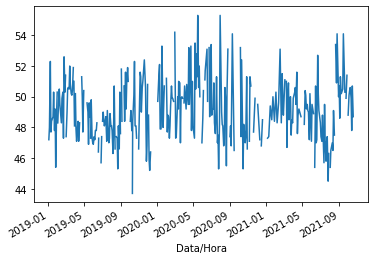

In [15]:
df['R28D'].plot()

<AxesSubplot:xlabel='Data/Hora'>

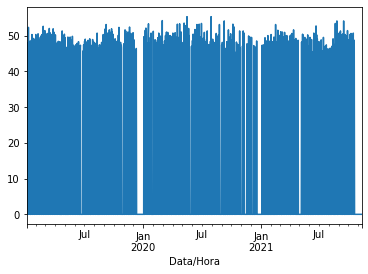

In [16]:
df.resample('24h').asfreq().fillna(0)['R28D'].plot()

<AxesSubplot:xlabel='Data/Hora'>

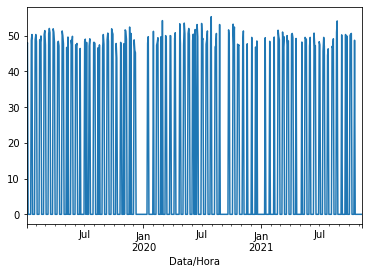

In [17]:
df.resample('48h').asfreq().fillna(0)['R28D'].plot()

<AxesSubplot:xlabel='Data/Hora'>

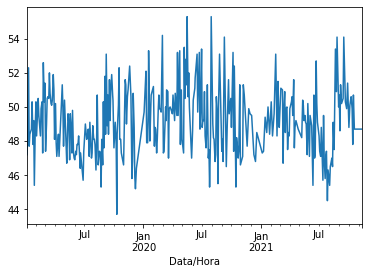

In [18]:
df.resample('24h').interpolate(method='linear', limit_direction="both")['R28D'].plot()

<AxesSubplot:xlabel='Data/Hora'>

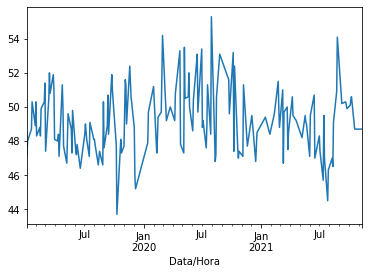

In [19]:
df.resample('48h').interpolate(method='linear', limit_direction="both")['R28D'].plot()

<AxesSubplot:xlabel='Data/Hora'>

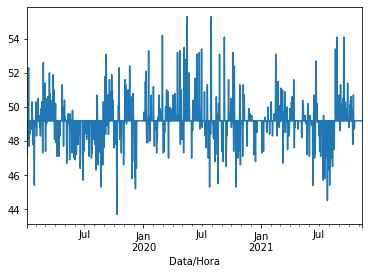

In [20]:
df.resample('24h').asfreq().fillna(df.resample('48h').asfreq().mean())['R28D'].plot()

<AxesSubplot:xlabel='Data/Hora'>

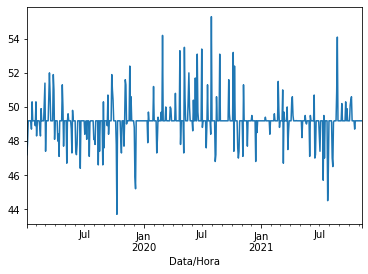

In [21]:
df.resample('48h').asfreq().fillna(df.resample('48h').asfreq().mean())['R28D'].plot()

# Synthetic Features

In [22]:
scaler = StandardScaler()
model = LinearRegression()

In [23]:
geomean = lambda x, axis : np.exp(np.mean(np.log(x), axis=axis))
harmonic_mean = lambda x, axis : len(x) / np.sum(1.0/x, axis=axis) 

funcs = {'mean' : np.mean, 
         'std' : np.std, 
         'var' : np.var, 
         'geo_mean' : geomean, 
         'harmonic_mean' : harmonic_mean, 
         'median' : np.median,
         'none' : None}

<h3>GridCV - Without R3D And R7D vars<h3>

In [24]:
results, names = list(), list()
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=47)
data = df.resample('48h').interpolate(method='linear', limit_direction="both")

for statistic, func in funcs.items():
    scores = []
    data_copy = data.copy().drop(['R3D', 'R7D'], axis=1)
    y = data_copy.pop('R28D').values
    
    if func is not None:
        data_copy[statistic] = func(data_copy, axis=1)
    
    x = data_copy.values
    
    for train, test in rkf.split(x):
        model.fit(scaler.fit_transform(x[train]), y[train])
        rmse = mean_squared_error(y[test], model.predict(scaler.transform(x[test])), squared=False)
        scores.append(rmse)
    results.append(scores)
    names.append(statistic)
    print('>%s: %.3f (%.3f)' % (statistic, np.mean(scores), np.std(scores)))

mean_results = list(map(np.mean, results))
index = np.argmin(mean_results)
name = names[index]
print("\nBest method:", name, '\nbest rmse score:', mean_results[index])

>mean: 1.400 (0.152)
>std: 1.400 (0.151)
>var: 1.398 (0.155)


/home/felipe/Documents/ccs28-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


>geo_mean: 1.401 (0.151)
>harmonic_mean: 1.400 (0.151)
>median: 1.402 (0.154)
>none: 1.398 (0.151)

Best method: none 
best rmse score: 1.397969200009413


<h3>GridCV - Without R7D var<h3>

In [25]:
model = LinearRegression()
results, names = list(), list()
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=47)
data = df.resample('48h').interpolate(method='linear', limit_direction="both")

for statistic, func in funcs.items():
    scores = []
    data_copy = data.copy().drop(['R7D'], axis=1)
    y = data_copy.pop('R28D').values
    
    if func is not None:
        data_copy[statistic] = func(data_copy, axis=1)
    
    x = data_copy.values
    
    for train, test in rkf.split(x):
        model.fit(scaler.fit_transform(x[train]), y[train])
        rmse = mean_squared_error(y[test], model.predict(scaler.transform(x[test])), squared=False)
        scores.append(rmse)
    results.append(scores)
    names.append(statistic)
    print('>%s: %.3f (%.3f)' % (statistic, np.mean(scores), np.std(scores)))

mean_results = list(map(np.mean, results))
index = np.argmin(mean_results)
name = names[index]
print("\nBest method:", name, '\nbest rmse score:', mean_results[index])

>mean: 1.317 (0.145)
>std: 1.321 (0.146)
>var: 1.319 (0.147)


/home/felipe/Documents/ccs28-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


>geo_mean: 1.318 (0.145)
>harmonic_mean: 1.317 (0.145)
>median: 1.307 (0.148)
>none: 1.316 (0.145)

Best method: median 
best rmse score: 1.3068491855813904


<h3>GridCV - All vars<h3>

In [26]:
model = LinearRegression()
results, names = list(), list()
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
data = df.resample('48h').interpolate(method='linear', limit_direction="both")

for statistic, func in funcs.items():
    scores = []
    data_copy = data.copy()
    y = data_copy.pop('R28D').values
    
    if func is not None:
        data_copy[statistic] = func(data_copy, axis=1)
        
    x = data_copy.values
    
    for train, test in rkf.split(x):
        model.fit(scaler.fit_transform(x[train]), y[train])
        rmse = mean_squared_error(y[test], model.predict(scaler.transform(x[test])), squared=False)
        scores.append(rmse)
    results.append(scores)
    names.append(statistic)
    print('>%s: %.3f (%.3f)' % (statistic, np.mean(scores), np.std(scores)))

mean_results = list(map(np.mean, results))
index = np.argmin(mean_results)
name = names[index]
print("\nBest method:", name, '\nbest rmse score:', mean_results[index])

>mean: 1.223 (0.140)
>std: 1.228 (0.143)
>var: 1.227 (0.146)


/home/felipe/Documents/ccs28-venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log
  """Entry point for launching an IPython kernel.


>geo_mean: 1.225 (0.140)
>harmonic_mean: 1.226 (0.141)
>median: 1.216 (0.141)
>none: 1.223 (0.140)

Best method: median 
best rmse score: 1.2161596103155732


<h2>Here we will add information about the count of missing values on each row</h2>

<h3>Repeated KFold - Without R3D And R7D vars<h3>

In [27]:
model = LinearRegression()
scores = list()
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
data = df.resample('48h').interpolate(method='linear', limit_direction="both")
data_copy = data.copy().drop(['R3D', 'R7D'], axis=1)
y = data_copy.pop('R28D').values
# data_copy['harmonic_mean'] = harmonic_mean(data_copy, axis=1)
data_copy['missing'] = df.resample('48h').asfreq().drop(['R28D'], axis=1).isna().sum(axis=1)
x = data_copy.values
    
for train, test in rkf.split(x):
    model.fit(scaler.fit_transform(x[train]), y[train])
    rmse = mean_squared_error(y[test], model.predict(scaler.transform(x[test])), squared=False)
    scores.append(rmse)

print('>%.3f (%.3f)' % (np.mean(scores), np.std(scores)))

>1.402 (0.153)


<h3>Repeated KFold - Without R7D var<h3>

In [28]:
model = LinearRegression()
scores = list()
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
data = df.resample('48h').interpolate(method='linear', limit_direction="both")
data_copy = data.copy().drop(['R7D'], axis=1)
y = data_copy.pop('R28D').values
data_copy['median'] = np.median(data_copy, axis=1)
data_copy['missing'] = df.resample('48h').asfreq().drop(['R28D'], axis=1).isna().sum(axis=1)
x = data_copy.values
    
for train, test in rkf.split(x):
    model.fit(scaler.fit_transform(x[train]), y[train])
    rmse = mean_squared_error(y[test], model.predict(scaler.transform(x[test])), squared=False)
    scores.append(rmse)

print('>%.3f (%.3f)' % (np.mean(scores), np.std(scores)))

>1.308 (0.151)


<h3>Repeated KFold - All vars<h3>

In [29]:
model = LinearRegression()
scores = list()
rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=seed)
data = df.resample('48h').interpolate(method='linear', limit_direction="both")
data_copy = data.copy()
y = data_copy.pop('R28D').values
data_copy['median'] = np.median(data_copy, axis=1)
data_copy['missing'] = df.resample('48h').asfreq().drop(['R28D'], axis=1).isna().sum(axis=1)
x = data_copy.values
    
for train, test in rkf.split(x):
    model.fit(scaler.fit_transform(x[train]), y[train])
    rmse = mean_squared_error(y[test], model.predict(scaler.transform(x[test])), squared=False)
    scores.append(rmse)

print('>%.3f (%.3f)' % (np.mean(scores), np.std(scores)))

>1.218 (0.143)


# Save the transformed dataset

In [30]:
df = pd.read_excel(xls, 'CPIIF40', na_values='-')
to_drop = ['ANIDRITA', 'MUSCOVITA', 'FALSAP', 'AE1D', 'AE28D', 'AE7D', 'ANIDRITA', 'DOLOMITA', 'FLUORITA', '#200']
df.drop(columns=to_drop, inplace=True)
df = df.set_index("Data/Hora")
df_resampled = df.resample('48h').interpolate(method='linear', limit_direction="both").copy()
df_r3d_and_r7d = df_resampled.copy()
df_r3d_only = df_resampled.copy().drop(['R7D'], axis=1)
df_no_r3d_r7d = df_resampled.drop(['R3D', 'R7D'], axis=1)

In [31]:
df_no_r3d_r7d['harmonic_mean'] = harmonic_mean(df_no_r3d_r7d.drop(['R28D'], axis=1), axis=1)
df_r3d_only['harmonic_mean'] = np.var(df_r3d_only.drop(['R28D'], axis=1), axis=1) 
df_r3d_and_r7d['var'] = np.var(df_r3d_and_r7d.drop(['R28D'], axis=1), axis=1)

In [32]:
# df_no_r3d_r7d['missing'] = df.resample('48h').asfreq().drop(['R28D', 'R3D', 'R7D'], axis=1).isna().sum(axis=1)
# df_r3d_only['missing'] = df.resample('48h').asfreq().drop(['R28D', 'R7D'], axis=1).isna().sum(axis=1)
# df_r3d_and_r7d['missing'] = df.resample('48h').asfreq().drop(['R28D'], axis=1).isna().sum(axis=1)

In [33]:
name = "dados-historicos-partner_i-cement-CPIIF40.csv"
df_r3d_and_r7d.to_csv("../../../data/interim/" + "r3d-and-r7d-" + name)
df_r3d_only.to_csv("../../../data/interim/" + "r3d-only-" + name)
df_no_r3d_r7d.to_csv("../../../data/interim/" + "no-r3d-r7d-" + name)

# Feature Engineering  Without Resampling

In [34]:
scaler = StandardScaler()
model = LinearRegression()
seed = 47

In [35]:
df = pd.read_excel(xls, 'CPIIF40', na_values='-')
to_drop = ['ANIDRITA', 'MUSCOVITA', 'FALSAP', 'AE1D', 'AE28D', 'AE7D', 'ANIDRITA', 'DOLOMITA', 'FLUORITA', '#200']
df.drop(columns=to_drop, inplace=True)
df = df.set_index("Data/Hora")

<h3>1. First step:</h3> <h4>Drop all rows where the cement compressive strength (CCS28) values are missing</h4>

In [36]:
df=df[df["R28D"].notna()]

<h3>2. Second Step:</h3> <h4>Run a grid search to pick the most suitable method to fill the missing values on the other variables</h4>

We run a cross validation with k=10 on each kind of imputation method.

In [37]:
def make_repeated_k_fold(model, x, y, n_splits=10, n_repeats=10, scoring = 'neg_root_mean_squared_error'):
    cv = RepeatedKFold(n_splits=n_splits, n_repeats=n_repeats, random_state=seed)
    scores = cross_val_score(model, x, y, scoring=scoring, cv=cv, n_jobs=-1)
    return scores

In [38]:
def get_imputation_pipelines(data, cols_to_remove=None):
    pipelines = list()
    data_copy = data.copy()
    
    if cols_to_remove is not None:
            data_copy = data_copy.drop(cols_to_remove, axis=1)
    
    # fillna with zeros
    pipelines.append(('impute-zero', data_copy.fillna(0)))
    
    # fillna with mean
    pipelines.append(('impute-mean', data_copy.fillna(data_copy.mean())))
    
    # fillna with forward and backward fill
    pipelines.append(('impute-forward-backward-fill', data_copy.fillna(method='ffill').fillna(method='bfill')))
    
    # dropnas
    pipelines.append(('dropnas', data_copy.dropna()))
    
    return pipelines

In [39]:
def make_grid_search_with_k_fold(df, 
                                 cols_to_remove = None, 
                                 show_individual_results=True,
                                 show_final_result=True):
    results, names = list(), list()
    pipeline = Pipeline([('transformer', scaler), ('estimator', model)])
    
    for name, data in get_imputation_pipelines(df, cols_to_remove):
        y = data.pop('R28D').values
        x = data.values    
        scores = make_repeated_k_fold(pipeline, x, y, n_splits=10, n_repeats=10, scoring='neg_root_mean_squared_error')
        scores = np.abs(scores)
        results.append(scores)
        names.append(name)
        if show_individual_results:
            print('>%s: %.3f (%.3f)' % (name, np.mean(scores), np.std(scores)))

    mean_results = list(map(np.mean, results))
    index = np.argmin(mean_results)
    name = names[index]
    
    if show_final_result:
        print("\nBest method:", name, '\nbest rmse score:', mean_results[index])
    return names, results

<h3>GridCV - Without R3D And R7D vars<h3>

In [40]:
names, results = make_grid_search_with_k_fold(df=df, cols_to_remove=["R3D", "R7D"])

>impute-zero: 1.979 (0.413)
>impute-mean: 1.971 (0.290)
>impute-forward-backward-fill: 1.933 (0.237)
>dropnas: 1.988 (0.331)

Best method: impute-forward-backward-fill 
best rmse score: 1.9329949665786106


<h3>GridCV - Without R7D var<h3>

In [41]:
names, results = make_grid_search_with_k_fold(df=df, cols_to_remove="R7D")

>impute-zero: 2.016 (0.485)
>impute-mean: 1.678 (0.257)
>impute-forward-backward-fill: 1.651 (0.229)
>dropnas: 1.596 (0.285)

Best method: dropnas 
best rmse score: 1.5955976092055277


<h3>GridCV - All vars<h3>

In [42]:
names, results = make_grid_search_with_k_fold(df=df, cols_to_remove=None)

>impute-zero: 2.038 (0.552)
>impute-mean: 1.462 (0.206)
>impute-forward-backward-fill: 1.423 (0.174)
>dropnas: 1.406 (0.195)

Best method: dropnas 
best rmse score: 1.4057290704046332


# Saving the dataset with the transforms

In [43]:
df = pd.read_excel(xls, 'CPIIF40', na_values='-')
to_drop = ['ANIDRITA', 'MUSCOVITA', 'FALSAP', 'AE1D', 'AE28D', 'AE7D', 'ANIDRITA', 'DOLOMITA', 'FLUORITA', '#200']
df.drop(columns=to_drop, inplace=True)
df = df.set_index("Data/Hora")
df=df[df["R28D"].notna()]

<h3>Saving for linear regression and Neural Nets</h3>

In [44]:
df_r3d_and_r7d = df.dropna().copy()
df_r3d_only = df.drop(["R7D"], axis=1).dropna().copy()
df_no_r3d_r7d = df.drop(["R3D", "R7D"], axis=1).fillna(method='ffill').fillna(method='bfill').copy()
name = "dados-historicos-partner_i-cement-CPIIF40.csv"

df_r3d_and_r7d.to_csv("../../../data/interim/" + "r3d_and_r7d-no-resampling-with-fillna-" + name)
df_r3d_only.to_csv("../../../data/interim/" + "r3d_only-no-resampling-with-fillna-" + name)
df_no_r3d_r7d.to_csv("../../../data/interim/" + "no-r3d-r7d-no-resampling-with-fillna-" + name)

<h3>Saving for xgboost</h3>

In [45]:
df_r3d_and_r7d = df.copy()
df_r3d_only = df.drop(["R7D"], axis=1).copy()
df_no_r3d_r7d = df_no_r3d_r7d = df.drop(["R3D", "R7D"], axis=1).copy()
name = "dados-historicos-partner_i-cement-CPIIF40.csv"

df_r3d_and_r7d.to_csv("../../../data/interim/" + "r3d_and_r7d-no-resampling-without-fillna-" + name)
df_r3d_only.to_csv("../../../data/interim/" + "r3d_only-no-resampling-without-fillna-" + name)
df_no_r3d_r7d.to_csv("../../../data/interim/" + "no-r3d-r7d-no-resampling-without-fillna-" + name)